In [1]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

import re
import os
import os.path
import glob
from PIL import Image
from skimage import io

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
from vis.utils import utils
from keras.applications import VGG16
from vis.visualization import visualize_cam,visualize_saliency, overlay, visualize_activation, get_num_filters
from vis.input_modifiers import Jitter

from keras import activations

# Disable GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/malimg_paper_dataset_imgs"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in image.list_pictures(list_fams[i], ext='jpg|jpeg|bmp|png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        X[cnt] = x
        #x /= 255
        #x = preprocess_input(x)
        #X[cnt] = np.array(x).reshape(width*height*channels)
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [5]:
# Creating base model (VGG16 convolutional layers)
img_shape = (224, 224, 3)                                                                                                                                               
model = Sequential()

# Block 1
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', input_shape=img_shape))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

# Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

# Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

# Block 4
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

# Block 5
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))

In [6]:
vgg16weights = "vgg16_weights_tf_dim_ordering_tf_kernels.h5"
model.load_weights(vgg16weights, by_name=True)

In [7]:
# Stacking top model (fc and softmax layers)
model.add(Flatten())                                                
model.add(Dense(160, activation='relu', name='fc1'))
model.add(Dropout(0.4))                
model.add(Dense(160, activation='relu', name='fc2'))
model.add(Dropout(0.4))              
model.add(Dense(num_classes, activation='softmax', name='predictions'))                             

In [8]:
top_weigths = "top_model-weights-max_val_acc-mlp-vgg16-2layers-160neurons-relu-0.4dropout-Adam-500epochs.h5"
model.load_weights(top_weigths, by_name=True)

In [9]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'predictions')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

In [14]:
vis_images = []
image_modifiers = [Jitter(16)]
for idx,fam in enumerate(list_fams):    
    img = visualize_activation(model, layer_idx, filter_indices=idx, max_iter=500, input_modifiers=image_modifiers)
    
    # Reverse lookup index to imagenet label and overlay it on the image.
    img = utils.draw_text(img, fam)
    vis_images.append(img)

# Generate stitched images with 5 cols (so it will have 3 rows).
plt.rcParams['figure.figsize'] = (50, 50)
stitched = utils.stitch_images(vis_images, cols=5)
plt.axis('off')
plt.imshow(stitched)
plt.show()

Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed t

In [ ]:
# The name of the layer we want to visualize
# You can see this in the model definition.
layer_name = 'block1_conv2'
layer_idx = utils.find_layer_idx(model, layer_name)

# Visualize all filters in this layer.
filters = np.arange(get_num_filters(model.layers[layer_idx]))

# Generate input image for each filter.
vis_images = []
for idx in filters:
    img = visualize_activation(model, layer_idx, filter_indices=idx)
    
    # Utility to overlay text on image.
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    vis_images.append(img)

# Generate stitched image palette with 8 cols.
stitched = utils.stitch_images(vis_images, cols=8)    
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()

Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed t

Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default


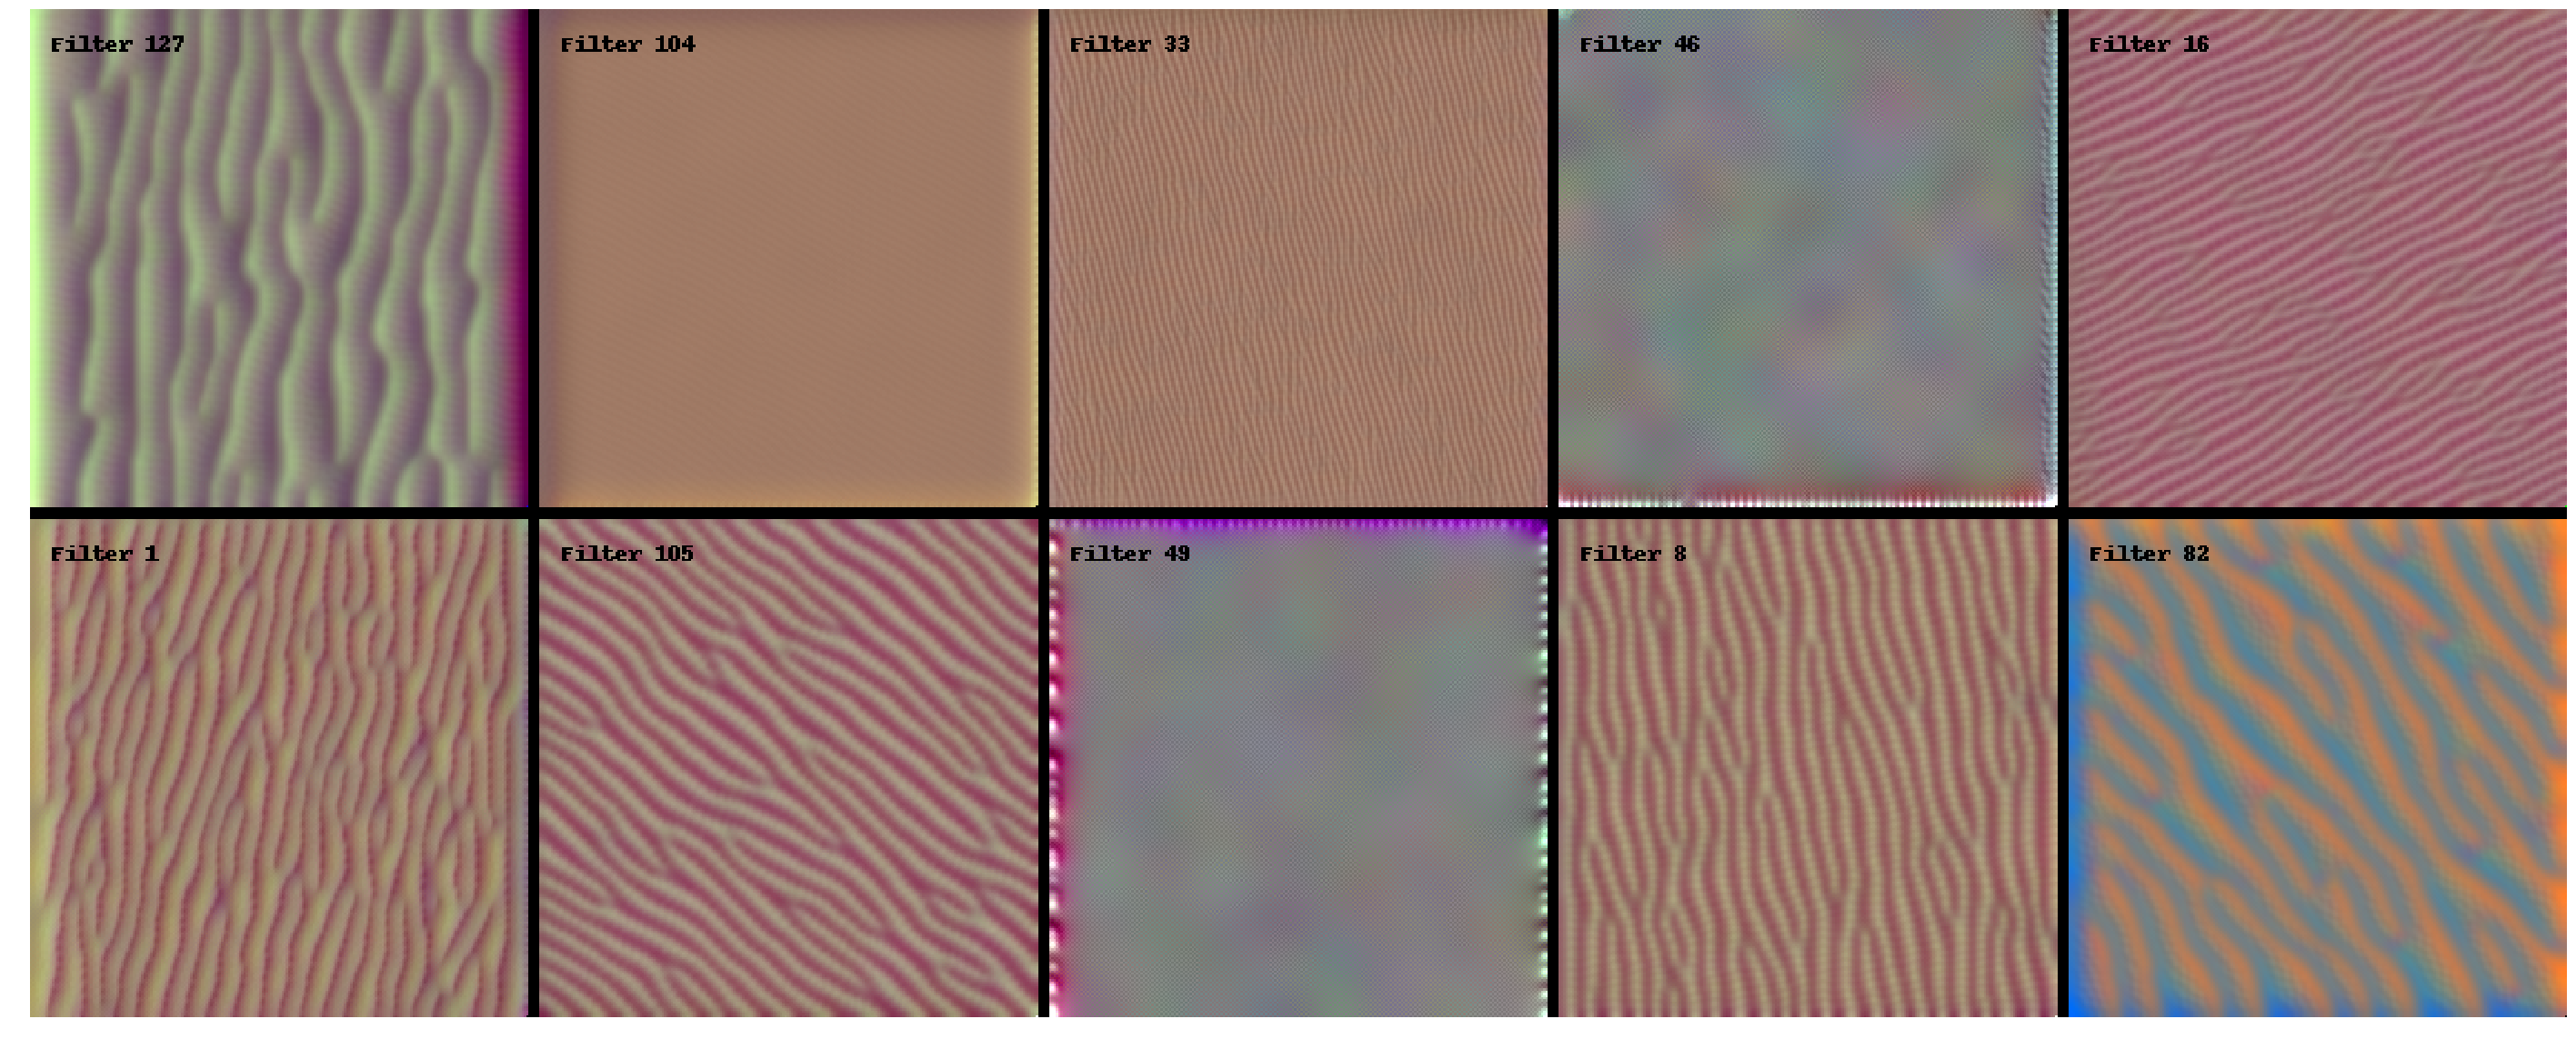

Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default


In [ ]:
selected_indices = []
for layer_name in ['block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']:
    layer_idx = utils.find_layer_idx(model, layer_name)

    # Visualize all filters in this layer.
    filters = np.random.permutation(get_num_filters(model.layers[layer_idx]))[:10]
    selected_indices.append(filters)

    # Generate input image for each filter.
    vis_images = []
    for idx in filters:
        img = visualize_activation(model, layer_idx, filter_indices=idx)

        # Utility to overlay text on image.
        img = utils.draw_text(img, 'Filter {}'.format(idx))    
        vis_images.append(img)

    # Generate stitched image palette with 5 cols so we get 2 rows.
    stitched = utils.stitch_images(vis_images, cols=5)    
    plt.figure()
    plt.axis('off')
    plt.imshow(stitched)
    plt.show()

In [ ]:
layer_idx = utils.find_layer_idx(model, 'block5_conv3')

# We need to select the same random filters in order to compare the results.
filters = selected_indices[-1]
selected_indices.append(filters)

# Generate input image for each filter.
vis_images = []
for idx in filters:
    # We will jitter 5% relative to the image size.
    img = visualize_activation(model, layer_idx, filter_indices=idx, 
                               tv_weight=0.,
                               input_modifiers=[Jitter(0.05)])

    # Utility to overlay text on image.
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    vis_images.append(img)

# Generate stitched image palette with 5 cols so we get 2 rows.
stitched = utils.stitch_images(vis_images, cols=5)    
plt.figure()
plt.axis('off')
plt.imshow(stitched)
plt.show()

In [ ]:
# Generate input image for each filter.
new_vis_images = []
for i, idx in enumerate(filters):
    # We will seed with optimized image this time.
    img = visualize_activation(model, layer_idx, filter_indices=idx, 
                               seed_input=vis_images[i],
                               input_modifiers=[Jitter(0.05)])

    # Utility to overlay text on image.
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    new_vis_images.append(img)

# Generate stitched image palette with 5 cols so we get 2 rows.
stitched = utils.stitch_images(new_vis_images, cols=5)    
plt.figure()
plt.axis('off')
plt.imshow(stitched)
plt.show()

In [ ]:
samplesbyfamily = 5 
for fam in list_fams:
    print("Family: %s" %(fam))
    fam_samples = [name for name in list_paths if fam in name]
    image_paths = random.sample(fam_samples, samplesbyfamily)
    
    #fig = plt.figure(figsize=(16, 8))
    f, ax = plt.subplots(6, samplesbyfamily)
    f.set_size_inches(3*samplesbyfamily, 3*6)
    ind = 0
    
    for path in image_paths:
        # Predict the corresponding class for use in `visualize_cam`.
        img = io.imread(path)
        img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
        img = cv2.resize(img, (224, 224))
        pred_class = np.argmax(model.predict(np.array([img_to_array(img)])))
        print("Image: %s - Class: %s - Pred: %d (%s)" %(path.split('/')[-1:],path.split('/')[-2:-1],pred_class,list_fams[pred_class]))
        
        grads = visualize_saliency(model, layer_idx, filter_indices=[pred_class], seed_input=img)
        gradsguided = visualize_saliency(model, layer_idx, filter_indices=[pred_class], seed_input=img, backprop_modifier='guided')
        gradsrelu = visualize_saliency(model, layer_idx, filter_indices=[pred_class], seed_input=img, backprop_modifier='relu')
        heatmap = visualize_cam(model, layer_idx, filter_indices=[pred_class], seed_input=img)        
        heatmapguided = visualize_cam(model, layer_idx, filter_indices=[pred_class], seed_input=img, backprop_modifier='guided')        
        heatmaprelu = visualize_cam(model, layer_idx, filter_indices=[pred_class], seed_input=img, backprop_modifier='relu')        

        ax[0,ind].axis('off')
        ax[0,ind].imshow(grads, cmap='jet')
        ax[1,ind].axis('off')
        ax[1,ind].imshow(gradsguided, cmap='jet')
        ax[2,ind].axis('off')
        ax[2,ind].imshow(gradsrelu, cmap='jet')
        ax[3,ind].axis('off')
        ax[3,ind].imshow(overlay(heatmap, img))
        ax[4,ind].axis('off')
        ax[4,ind].imshow(overlay(heatmapguided, img))
        ax[5,ind].axis('off')
        ax[5,ind].imshow(overlay(heatmaprelu, img))
        ind = ind + 1
        
    plt.show()